# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Imports

In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
import glob
import cv2
from tensorflow.contrib.layers import flatten
%matplotlib notebook

## Seed RNG

In [2]:
np.random.seed(0)

---
## Step 0: Load The Data

In [3]:
# Load pickled data
data_directory = "data"
training_file = os.path.join(data_directory, "train.p")
validation_file= os.path.join(data_directory, "valid.p")
testing_file = os.path.join(data_directory, "test.p")

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
# Note that the feature sets are "raw" because they have not been preprocessed yet
X_train_raw, y_train = train['features'], train['labels']
X_valid_raw, y_valid = valid['features'], valid['labels']
X_test_raw, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [86]:
# Number of training examples
n_train = X_train_raw.shape[0]

# Number of validation examples
n_validation = X_valid_raw.shape[0]

# Number of testing examples.
n_test = X_test_raw.shape[0]

# Image shape
image_shape = X_test_raw.shape[1:]

# Number of classes
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory Visualization of the Dataset

The frequency of each class is plotted in a histogram for the training, validation, and test labels. The histogram show that the training, validation, and test sets have roughly the same proportions of each class label, but some classes are represented much more than others. Particularly, classes 20-42 are less represented than classes 1-18. This may be acceptable, however, since some traffic signs are much more common than others in the real world. For example, speed limit signs (classes 0-5, 7, and 8), are more common than "roundabout mandatory" signs (class 40).

<IPython.core.display.Javascript object>


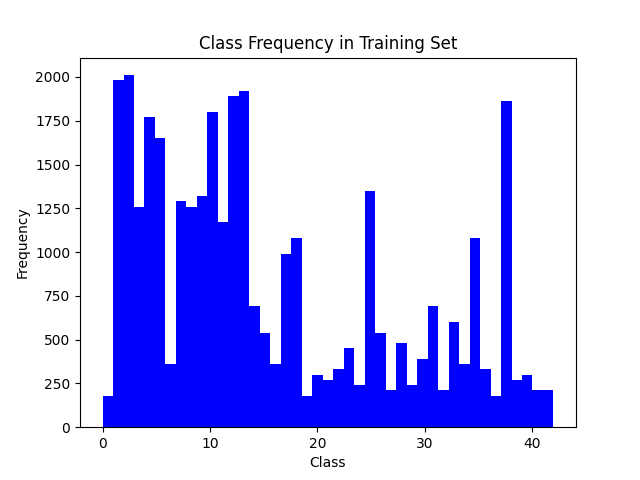

<IPython.core.display.Javascript object>


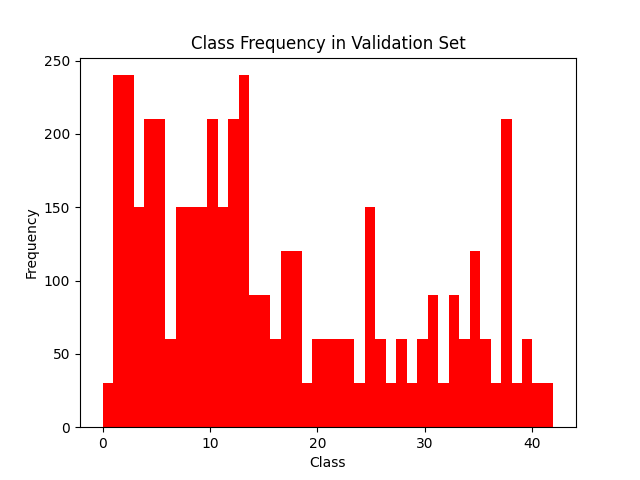

<IPython.core.display.Javascript object>


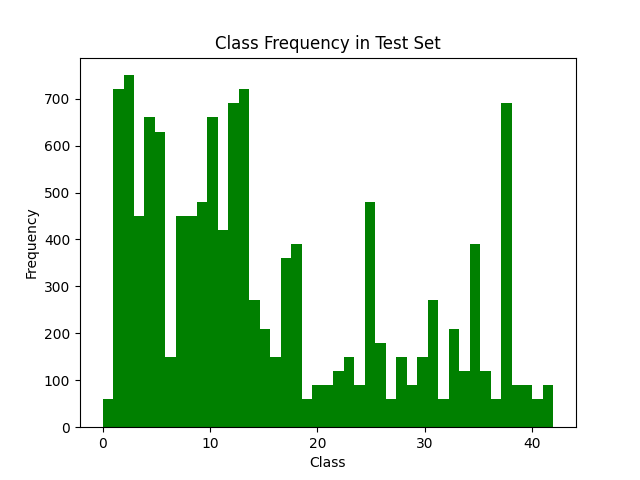

In [88]:
def plot_class_frequency_histogram(y, title, color="b"):
    plt.figure()
    plt.hist(y, bins=n_classes, color=color)
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.title(title)
    
plot_class_frequency_histogram(y_train, "Class Frequency in Training Set", color="b")
plot_class_frequency_histogram(y_valid, "Class Frequency in Validation Set", color="r")
plot_class_frequency_histogram(y_test, "Class Frequency in Test Set", color="g")

plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test the model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is used as a starting point.

With the LeNet-5 solution from the lecture, the validation set accuracy is about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and is used in this project. 

In [6]:
def normalize_features(X):
    return (X - 128.0)/128.0

def preprocess_features(X):
    return normalize_features(X)

# After preprocessing the raw feature sets, do not call them "raw" anymore
X_train, X_valid, X_test = map(preprocess_features, (X_train_raw, X_valid_raw, X_test_raw))

### Model Architecture

In [7]:
# LeNet architecture from CNN lesson LeNet lab is used as a starting point.
# Two new convolutional layers are added in the middle of the network.


def LeNet_Modified(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6, Activation=ReLU (originally part of LeNet)
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)
    
    # New convolutional layer
    # Input = 28x28x6
    # Output = 28x28x6
    # Activation= ReLU
    new_conv1_W = tf.Variable(tf.truncated_normal(shape=(7, 7, 6, 6), mean=mu, stddev=sigma))
    new_conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(conv1, new_conv1_W, strides=[1, 1, 1, 1], padding="SAME") + new_conv1_b
    conv1 = tf.nn.relu(conv1)
    
    # Pooling. Input = 28x28x6. Output = 14x14x6 (originally part of LeNet)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16 (originally part of LeNet)
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # New convolutional layer
    # Input = 10x10x16
    # Output = 10x10x16
    # Activation: ReLU
    new_conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 16), mean=mu, stddev=sigma))
    new_conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv2, new_conv2_W, strides=[1, 1, 1, 1], padding="SAME") + new_conv2_b
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16 (originally part of LeNet)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400 (originally part of LeNet)
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120, Activation = ReLU (originally part of LeNet).
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84, Activation = ReLU (originally part of LeNet).
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = n_classes (43) (originally part of LeNet)
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [8]:
# Create placeholders for features and labels
x = tf.placeholder(tf.float32, (None, *X_train.shape[1:]))
y = tf.placeholder(tf.int32, (None))

# One-hot encode the labels
one_hot_y = tf.one_hot(y, n_classes)

# Learning rate for Adam optimizer
learning_rate = 0.001

# Output of LeNet_Modified is a vector of logits
logits = LeNet_Modified(x)

# Softmax is applied to the logits after the network to compute cross entropy
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

# Loss function is defined as the mean cross entropy over all the input data
loss_operation = tf.reduce_mean(cross_entropy)

# Adam optimizer is used to minimize the loss
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [9]:
EPOCHS = 20
BATCH_SIZE = 128

In [10]:
# Calculate accuracy of predictions using argmax of logis and one-hot labels
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [11]:
accuracy_achieved = False
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = X_train.shape[0]
    for i in range(EPOCHS):
        print("EPOCH {} ...".format(i+1))
        
        # At the start of each epoch, shuffle the training set
        X_train, y_train = shuffle(X_train, y_train)
        
        # Process the shuffled training set batch by batch
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        
        # After training on all of the batches, print out information about how the training is going
        train_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)

        print("Train Accuracy = {:.3f}".format(train_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
        # If the desired validation accuracy is achieved, stop training
        if validation_accuracy >= 0.93:
            accuracy_achieved = True
            break
        
    # If the desired validation accuracy has been achieved, save the model
    if accuracy_achieved:    
        saver.save(sess, './model')
        print("Model saved after achieving {} % validation accuracy".format(round(validation_accuracy*100, 2)))

    

EPOCH 1 ...
Train Accuracy = 0.913
Validation Accuracy = 0.833

EPOCH 2 ...
Train Accuracy = 0.965
Validation Accuracy = 0.884

EPOCH 3 ...
Train Accuracy = 0.977
Validation Accuracy = 0.898

EPOCH 4 ...
Train Accuracy = 0.983
Validation Accuracy = 0.912

EPOCH 5 ...
Train Accuracy = 0.984
Validation Accuracy = 0.907

EPOCH 6 ...
Train Accuracy = 0.993
Validation Accuracy = 0.924

EPOCH 7 ...
Train Accuracy = 0.990
Validation Accuracy = 0.912

EPOCH 8 ...
Train Accuracy = 0.992
Validation Accuracy = 0.912

EPOCH 9 ...
Train Accuracy = 0.994
Validation Accuracy = 0.912

EPOCH 10 ...
Train Accuracy = 0.991
Validation Accuracy = 0.919

EPOCH 11 ...
Train Accuracy = 0.995
Validation Accuracy = 0.933

Model saved after achieving 93.33 % validation accuracy


---

## Step 3: Test the Model on New Images

Five pictures of German traffic signs were downloaded from the Internet and passed to the model to predict the traffic sign types. The images are located in the directory [`data\real`](./data/real). The names of the images indicate the expected class of the image, as encoded in [`signnames.csv`](./signnames.csv). For example, `14.jpg` is an image of a German stop sign, and `signnames.csv` indicates that 14 is the class ID for stop signs. This naming convention is used to generate the labels of the real world images.

### Load and Output the Images

<IPython.core.display.Javascript object>


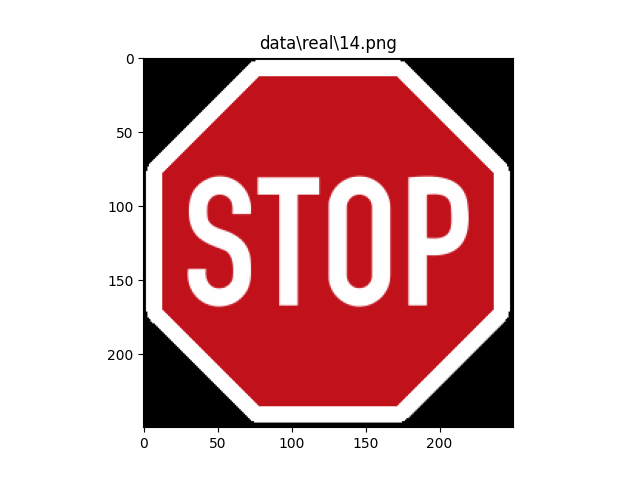

<IPython.core.display.Javascript object>


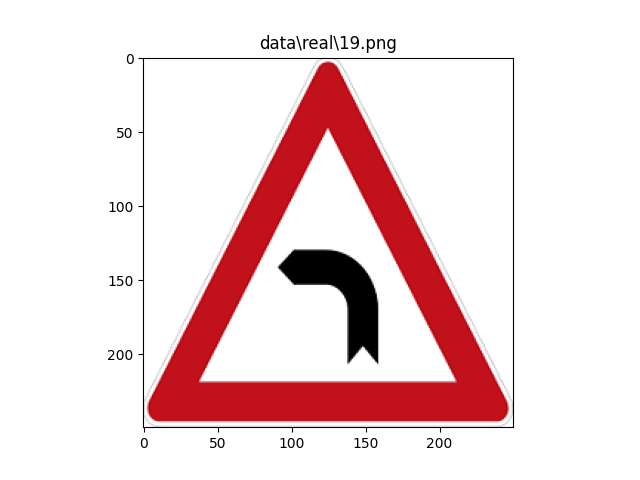

<IPython.core.display.Javascript object>


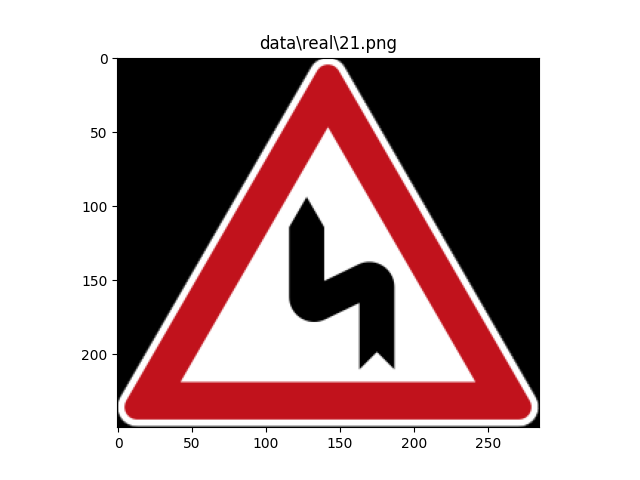

<IPython.core.display.Javascript object>


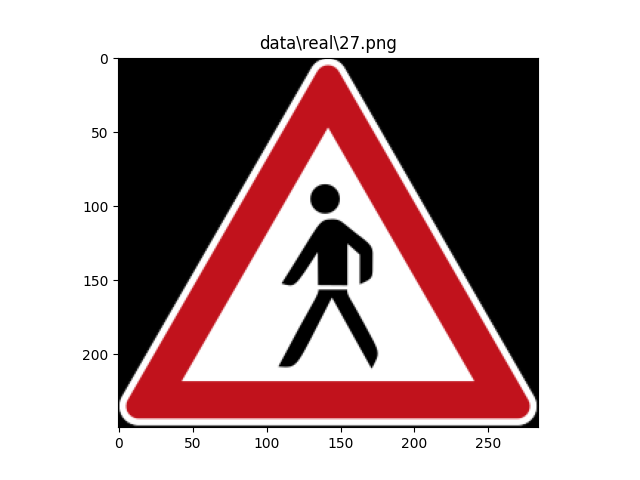

<IPython.core.display.Javascript object>


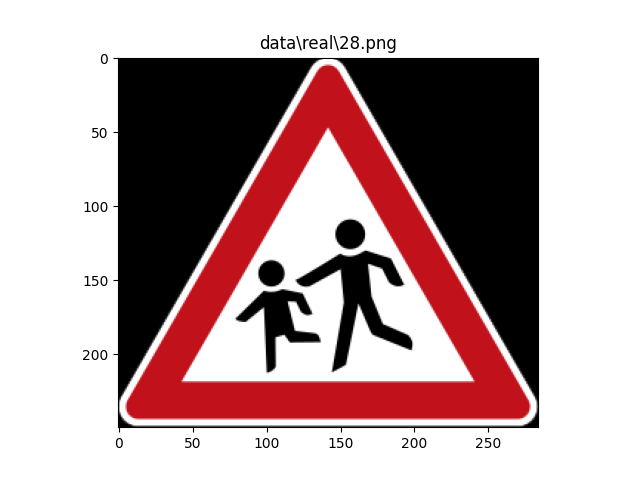

In [94]:
### Load the images and plot them
real_world_images = glob.glob(os.path.join("data", "real", "*.png"))
imgs = [cv2.cvtColor(cv2.imread(real), cv2.COLOR_BGR2RGB) for real in real_world_images]

for fname, img in zip(real_world_images, imgs):
    plt.figure()
    plt.imshow(img)
    plt.title(fname)
plt.show()

In [95]:
# Resize the images to the expected input size of 32 x 32
imgs = [cv2.resize(img, X_train.shape[1:3]) for img in imgs]
imgs_arr = np.zeros((len(imgs), *imgs[0].shape))

# Preprocess the images
for i in range(imgs_arr.shape[0]):
    imgs_arr[i] = preprocess_features(imgs[i])
    
# Store result of resizing and preprocessing as a numpy array
imgs = imgs_arr

In [96]:
# Generate labels vector based on filenames of each image
labels = os.listdir(os.path.join("data", "real"))
for i in range(len(labels)):
    labels[i] = int(labels[i].split('.')[0])
labels = np.array(labels)

### Predict the Sign Type for Each Image and Analyze Performance

In [16]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(imgs, labels)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from .\model
Test Accuracy = 1.000


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image).

In [82]:
def top_k(arr, k, axis):
    return np.sort(arr, axis=axis)[:, -k:]

def softmax(x):
    expx = np.exp(x)
    expx_sum = np.sum(expx, axis=1).reshape(-1, 1)
    return expx/expx_sum

In [85]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    logits_rw = sess.run(logits, feed_dict = {x: imgs})

softmax_rw = softmax(logits_rw)
print(top_k(softmax_rw, 5, axis=1))

INFO:tensorflow:Restoring parameters from .\model
[[1.7834708e-09 7.3817028e-09 1.5713220e-02 1.8901486e-02 9.6538520e-01]
 [2.2921250e-14 1.7079377e-13 3.9488763e-09 3.1448050e-07 9.9999964e-01]
 [6.2573118e-13 8.9442672e-12 7.2985089e-09 4.7641663e-08 9.9999988e-01]
 [2.8055538e-15 3.9995460e-15 8.8039791e-14 8.2742745e-12 1.0000000e+00]
 [3.9801948e-10 3.1018936e-07 4.0136814e-07 1.9228457e-03 9.9807644e-01]]


The softmax probabilities for the five images show that the network is quite confident in its predictions.
The second highest probabilities for each image are:
* 2E-2
* 3E-7
* 5E-8
* 8E-12
* 2E-3

### Project Writeup

The writeup is called [`writeup.md`](./writeup.md). 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.